## 1 - Project Overview

This customer segmentation project was created in order to solve a marketing problem where promotion campaigns would fall short of expectations. Our campaigns usually consisted of sales of digital analytics courses for marketers, and of membership signups. 

When running a marketing campaign on a large list of customers or email subscribers (i.e. email list with 50,000+ subscribers), it is vital to segment those lists by interests, purchase histories, and behaviors. Without segmentation, marketing campaigns are likely to fail. Without machine learning, segmentation was usually done by guesswork using "ideal customer profiles". 

The challenge is that this approach is very tedious when dealing with an email list of 75k subscribers, or when offering 30+ different products (as is usually the case with a catalog of various training courses). Which was VERY tedious work on an email list with 75,000 subscribers and 30+ different products. We had some some hits and misses with this "manual" method.

This project aims to solve this segmentation challenge using an unsupervised machine learning model that shows how the customer list is "clustered". These clusters can be used to glean insights about each group, and assign segment labels. Subsequently, these labels can then be used to train and test a classification algorithm.

## 2 - Data Analysis

I built this project for my specific use case using a specific dataset downloaded as a .csv file from Kajabi. 

See Kajabi: https://kajabi.com/

This dataset includes customer information, which is scrubbed in the preprocessing phase prior to modeling. Only the following columns are used in the model:

<style>
  table {
    max-width: 100%; /* Adjust the width as needed */
    text-align: left;
  }
  td {
    padding: 8px; /* Adding padding for better readability */
  }
</style>

<table>
    <thead>
        <tr>
            <th>Column</th>
            <th>Data Type</th>
            <th>Description</th>
        </tr>
        <tr>
            <td>ID</td>
            <td>Integer</td>
            <td>Unique user key in lieu of email or any PII</td>
        </tr>
        <tr>
            <td>Products</td>
            <td>String</td>
            <td>Comma-delimited list of products the user has purchased</td>
        </tr>
        <tr>
            <td>Tags</td>
            <td>String</td>
            <td>Comma-delimited list of tags indicating user behaviors and interests</td>
        </tr>
        <tr>
            <td>Created At</td>
            <td>DateTime</td>
            <td>Date when the user account has first been created</td>
        </tr>
        <tr>
            <td>Sign In Count</td>
            <td>Integer</td>
            <td>Total number of time the user has logged into their account</td>
        </tr>
        <tr>
            <td>Last Activity</td>
            <td>Integer</td>
            <td>Date of the last time when the user was active</td>
        </tr>
        <tr>
            <td>Last Sign In At</td>
            <td>Integer</td>
            <td>Date of the last time the user has logged into their account</td>
        </tr>
    </thead>
</table>

*Note: Only Kajabi datasets exported as raw .csv files will work here. Data from other sources than Kajabi will not work properly.*

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### 2.1 - Import the data

Assuming a raw .csv file as a full export from Kajabi, the dataset can be imported as follows:

*Warning: This will only work if you have access to the /data/ folder of this project and all the files within. Otherwise, this will result in an error.*

In [ ]:
import pandas as pd

df = pd.read_csv("../data/raw/DDU - Raw Kajabi Data.csv")

### 2.2 - Clean the data

Prune features we don't need from the dataset (including PII), then show the columns to make sure we have only the columns we need:

In [ ]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join("../src/")))

from data.make_dataset import prune_dataset
from data.data_cleaning import clean_dataset

df_pruned = prune_dataset(df)
df_pruned.info()

You may have noticed an extra column: 

```"Is_Member"```

The ```prune_dataset()``` function not only removed several columns, but also collapsed multiple columns indicating that the user is a paying member within the ecosystem. 

Next, clean the dataset and impute missing values. For example, ```'Last Activity'``` and ```'Last Sign In At'``` dates will be set equal to the ```'Created At'``` date if the user never logged in since the user's account was created.

Products and Tags also contained missing values in the form of empty strings, so these were replaced with "No Products" and "No Tags", respectively.

In [ ]:
df_cleaned = clean_dataset(df_pruned)
df_cleaned.info()

### 2.3 - Feature engineering

Before continuing, we also need to know how many products and tags each user has. Remember, the ```'Products'``` and ```'Tags'``` are comma-delimited lists of products and tags, respectively. We need to count how many of each a user has, and add those features to the dataset.

In [ ]:
from features.build_features import create_additional_features

df_filtered = create_additional_features(df_cleaned)
df_filtered.info()

During the same feature engineering process above, any rows with zero products and zero tags were dropped from the table as these users have no useful information to use in the model. 

This is why the ```df_filtered``` table has slightly less rows than the ```df_cleaned``` table.

### 2.4 - Exploratory Analysis

Using a custom plotting class, create some historgram plots to see the distribution of the number of products and tags across the user dataset.


In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

# Plot the first histogram
axs[0, 0].hist(df_filtered['Product_Count'], 
               bins=range(1, df_filtered['Product_Count'].max() + 2),
               color="blue")
axs[0, 0].set_title("Product Count Histogram")
axs[0, 0].set_xlabel("Number of Products")
axs[0, 0].set_ylabel("Number of Customers With X Number of Products")

# Plot the second histogram
axs[0, 1].hist(df_filtered['Tags_Count'], 
               bins=range(1, df_filtered['Tags_Count'].max() + 2),
               color="orange")
axs[0, 1].set_title("Tag Count Histogram")
axs[0, 1].set_xlabel("Number of Tags")
axs[0, 1].set_ylabel("Number of Customers With X Number of Tags")

# Q-Q plot for Product_Count
stats.probplot(df_filtered['Product_Count'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("Q-Q Plot for Product Count")

# Q-Q plot for Tags_Count
stats.probplot(df_filtered['Tags_Count'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot for Tags Count")

plt.tight_layout()
plt.show()

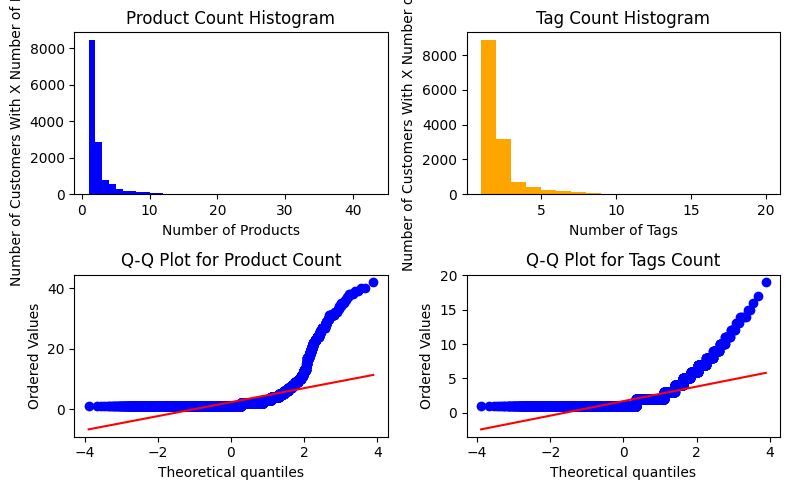

Since the product counts and tag counts are heavily skewed as shown by the QQ plots, these features will need to be transformed and normalized before training any model. 

For now, continue exploring other features, including how many times each customer has logged into their accounts. It will be interesting to break down and compare sign-in counts among members vs. non-members as well.

In [ ]:
# Plot sign-in histograms for all users, members only, and non-members
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 5))

# All Users
axs[0, 0].hist(df_filtered['Sign In Count'], 
        bins=df_filtered['Sign In Count'].max(),
        color="blue"
        )
axs[0, 0].set_title("All Users")
axs[0, 0].set_xlabel("Number of Sign-ins")
axs[0, 0].set_ylabel("Total Number of Customers")

# Members only
members = df_filtered[df_filtered["Is_Member"] == 1]["Sign In Count"]
axs[0, 1].hist(members, 
        bins=members.max(),
        color="green"
        )
axs[0, 1].set_title("Members Only")
axs[0, 1].set_xlabel("Number of Sign-ins")
axs[0, 1].set_ylabel("Total Number of Customers")

# Non-members
non_members = df_filtered[df_filtered["Is_Member"] == 0]["Sign In Count"]
axs[0, 2].hist(non_members, 
        bins=non_members.max(),
        color="orange"
        )
axs[0, 2].set_title("Non-Members")
axs[0, 2].set_xlabel("Number of Sign-ins")
axs[0, 2].set_ylabel("Total Number of Customers")

# Q-Q plot for All Users
stats.probplot(df_filtered['Sign In Count'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("Q-Q Plot for All Users")

# Q-Q plot for Members Only
stats.probplot(members, dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("Q-Q Plot for Members Only")

# Q-Q plot for Non-Members
stats.probplot(non_members, dist="norm", plot=axs[1, 2])
axs[1, 2].set_title("Q-Q Plot for Non-Members")

plt.tight_layout()
plt.show()

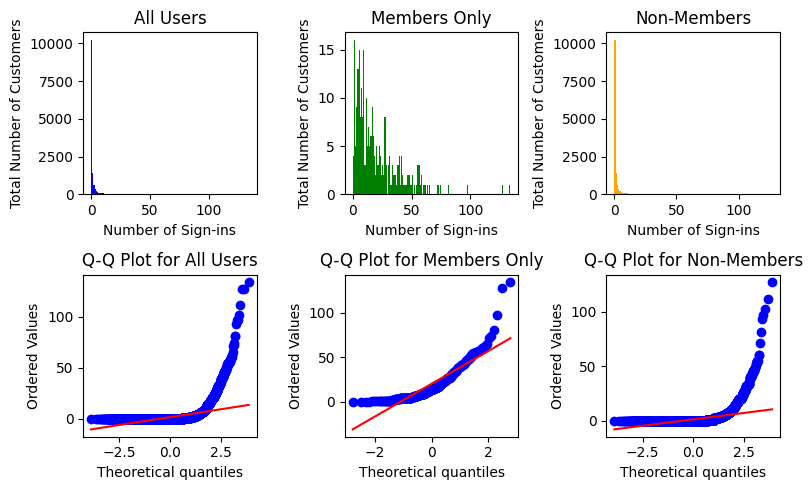

While it's interesting (and not surprising) that members have a much higher number of sign-ins than non-members do, the high number of zero values for sign-ins will present a challenge for model training and testing. 

Unfortunately, this feature may need to be omitted if most of the data needs to be preserved. The alternative will require dropping huge portions of the dataset if filtering out users who have never logged in after account creation. 

For now, I chose to preserve most of the data and exclude sign-in counts from feature selection.

<span style="color:orange">
Note: I tried applying an offset of +1 to all "count" features, but this did not materially change the distributions or QQ plots.
</span>

### 2.5 - Feature scaling

Given extremely skewed distributions in the above data, these features will need to be scaled and transformed before training a ML model.

I started with the RobustScaler() to see if it sufficiently normalizes the distributions.


In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

# Scale the product and tag counts
df_scaled = df_filtered.copy()
df_scaled = scaler.fit_transform(df_filtered[["Product_Count", "Tags_Count"]])
df_scaled = pd.DataFrame(df_scaled, columns=["Product_Count_Scaled", "Tags_Count_Scaled"])

# Check if the scaling adequately normalized the data
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

# Histogram for Product Count - Scaled
axs[0, 0].hist(df_scaled['Product_Count_Scaled'], 
               bins=range(1, df_filtered['Product_Count'].max() + 2),
               color="blue"
              )
axs[0, 0].set_title("Product Count - Scaled")
axs[0, 0].set_xlabel("Products")
axs[0, 0].set_ylabel("Customers")

# QQ Plot for Product Count - Scaled
stats.probplot(df_scaled['Product_Count_Scaled'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("QQ Plot - Product Count")

# Histogram for Tag Count - Scaled
axs[0, 1].hist(df_scaled['Tags_Count_Scaled'], 
               bins=range(1, df_filtered['Tags_Count'].max() + 2),
               color="orange"
              )
axs[0, 1].set_title("Tag Count - Scaled")
axs[0, 1].set_xlabel("Tags")
axs[0, 1].set_ylabel("Customers")

# QQ Plot for Tag Count - Scaled
stats.probplot(df_scaled['Tags_Count_Scaled'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("QQ Plot - Tag Count")

plt.tight_layout()
plt.show()

# Add the scaled product and tag counts to the original dataframe
df_filtered = df_filtered.join(df_scaled)


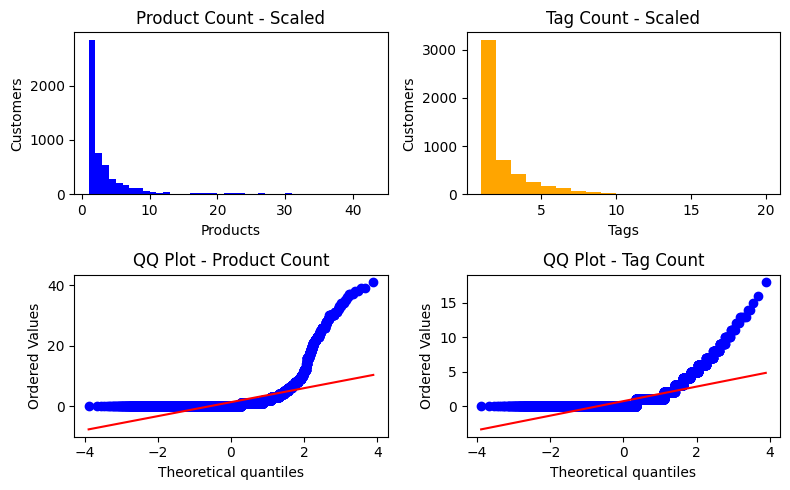

Better than unscaled as you can see in the y-axis, but the distribution is still not normal. QQ plot shows heavy right skew for each. However, there are some missing values after the scaler has been applied. This caused some downstream errors, so I decided to drop the ```_Scaled``` features in favor of ```Log_``` features as we'll create below. 

Next, I will try logarithmic transformation to see if I can get a more normal distribution.

In [ ]:
# Drop the "_Scaled" features from the table
df_filtered.drop(columns=["Product_Count_Scaled", "Tags_Count_Scaled"], inplace=True)

# Use the same scaler as declared above, but start with a fresh copy of the original unscaled but filtered dataframe
import numpy as np
from models.kmeans_clustering import LogTransformer

lf = LogTransformer()

df_transformed = df_filtered.copy()
df_transformed = lf.fit_transform(df_transformed)
df_transformed = pd.DataFrame(df_transformed, columns=["Log_Product_Count", "Log_Tags_Count"])


# Check if the scaling adequately normalized the data
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))

# Histogram for Log of Product Count - Scaled
axs[0, 0].hist(df_transformed['Log_Product_Count'], color="blue")
axs[0, 0].set_title("Log of Product Count")
axs[0, 0].set_xlabel("Products")
axs[0, 0].set_ylabel("Customers")

# QQ Plot for Log of Product Count - Scaled
stats.probplot(df_transformed['Log_Product_Count'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title("QQ Plot - Log of Product Count")

# Histogram for Log of Tag Count - Scaled
axs[0, 1].hist(df_transformed['Log_Tags_Count'], color="orange")
axs[0, 1].set_title("Log of Tag Count")
axs[0, 1].set_xlabel("Tags")
axs[0, 1].set_ylabel("Customers")

# QQ Plot for Log of Tag Count - Scaled
stats.probplot(df_transformed['Log_Tags_Count'], dist="norm", plot=axs[1, 1])
axs[1, 1].set_title("QQ Plot - Log of Tag Count")

plt.tight_layout()
plt.show()

# Add the transformed product and tag counts to the original dataframe
df_filtered = df_filtered.join(df_transformed)

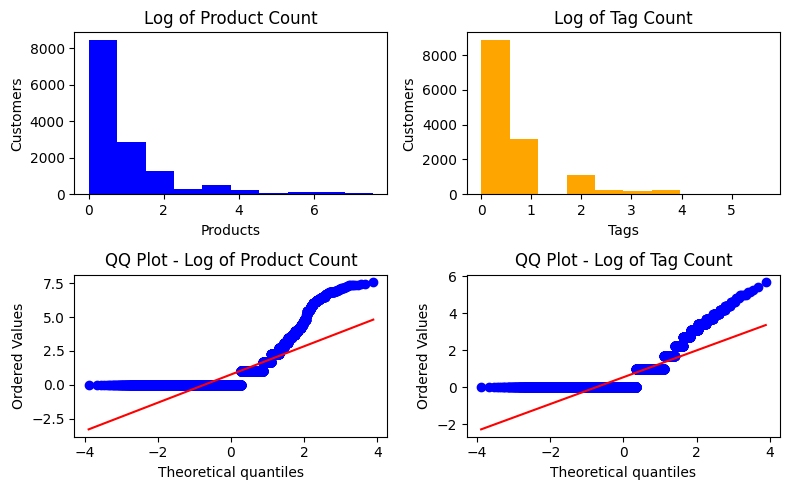

While these distributions aren't normal, the QQ plot y-axis scales on the log-transformed counts are much smaller than the non-transformed counts Because the y-axis has been scaled down, these transformed-scaled values can be used in the feature set as they won't bias the model results as much as the unscaled values might. However, there needs to be additional features that provides the model more information than merely how many products or tags each user has. 

### 2.6 - Product encoding

This brings about the next step of one-hot encoding product information under the ```Products``` column. But one-hot encoding will result in a very large and very sparse matrix since there are so many products (over 40 of them). Rather than one-hot encoding alone, I use a CountVectorizer() class to tokenize product names as well. CountVectorizer() accomplishes both one-hot encoding and tokenization in one step.

In [ ]:
from models.kmeans_clustering import BinaryMatrixTransformer

bmf = BinaryMatrixTransformer()
X_combined_prod = bmf.fit_transform(df_filtered)

selected_columns = X_combined_prod.iloc[:, 3:-3]
df_combined = pd.concat([df_filtered, selected_columns], axis=1)

### 2.7 - Principal Component Analysis

Since we now have over 60 features in the dataset, we need to apply a dimensionality reduction technique to find the most important features that explain the most variance towards clustering.

In [ ]:
from sklearn.decomposition import PCA

df_pca = X_combined_prod.copy()
predictor_columns = df_pca.columns[2:]

# Use PCA to plot visualization
pca_all = PCA(n_components=len(predictor_columns))
pca_all.fit(df_pca[predictor_columns])
explained_variance_ratios = pca_all.explained_variance_ratio_

plt.figure(figsize=(20, 6))
plt.bar(range(1, len(predictor_columns) + 1), explained_variance_ratios)
plt.xlabel("Principal Component Number")
plt.ylabel("Explained Variance")
plt.title("Explained Variance Ratios of Principal Components")
plt.show()

pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_combined_prod)

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_combined_prod)

# Explained variance can help understand the amount of information retained
print("Explained variance ratio (2D):", pca_2d.explained_variance_ratio_.sum())
print("Explained variance ratio (3D):", pca_3d.explained_variance_ratio_.sum())

# Add the PCA components to the original dataframe
df_combined['PCA_1'] = X_pca_3d[:, 0]
df_combined['PCA_2'] = X_pca_3d[:, 1]
df_combined['PCA_3'] = X_pca_3d[:, 2]

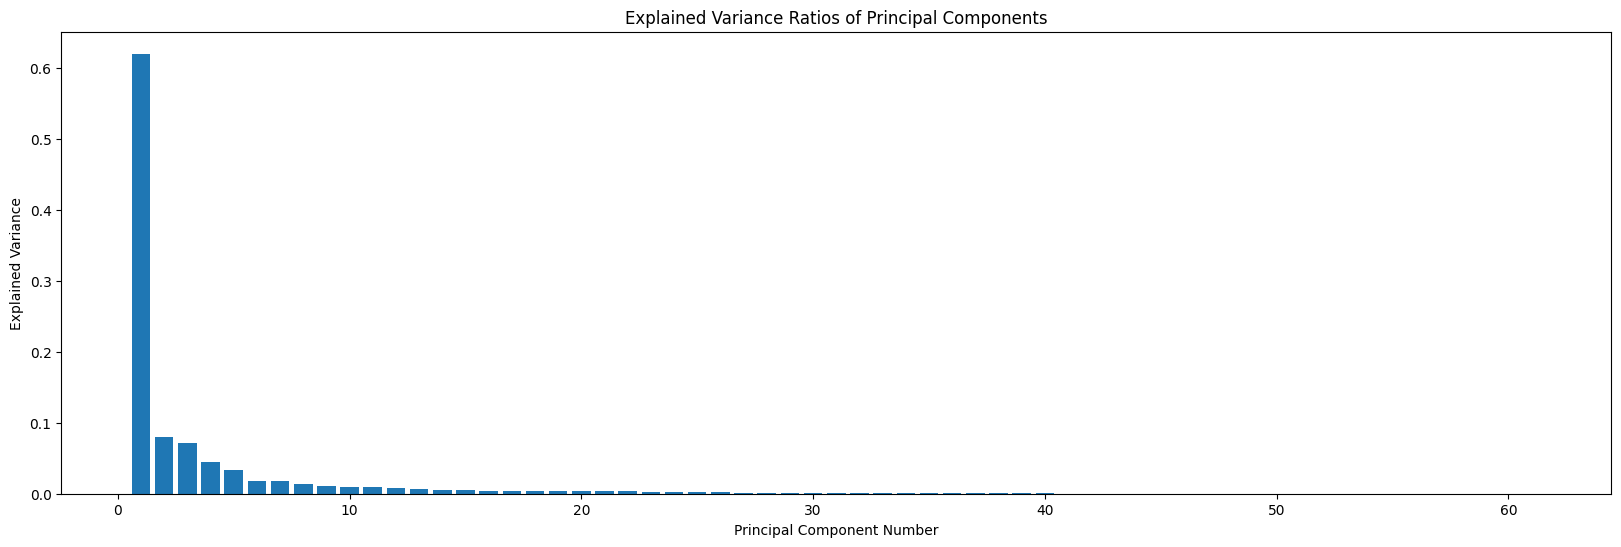

Using 3 components explains 76.6% of the variance, whereas 2 components explains 69.5%. Further increasing the number of ```n_components``` approaches a diminishing point of return. For simplicity and plotting purposes, decided to use 3 for ```n_components```.

Other dimensionality reduction techniques such as UMAP have been tested, but these did not score as well as PCA has. For this reason, PCA has been selected as the primary dimensionality reduction technique for KMeans (and any new clustering model I test going forward).

### 2.8 - Set aside a test set

Then split the dataset into a training set and a test set, but make sure it is stratified by product count to make sure both sets are balanced. Set ```random_state``` to an integer value to ensure reproducibility. 

Note: Although The test set will not be preprocessed in this notebook, all of the same data preprocessing steps described below will also be applied to the test set using scikit-learn's ```Pipeline()```.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# Initialize the StratifiedShuffleSplit
stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Filter out "rare" Product_Count values as there is no need to stratify those
df_fullset = df_combined.copy()
value_counts = df_combined['Product_Count'].value_counts()
to_keep = value_counts[value_counts >= 2].index
df_fullset = df_combined[df_combined['Product_Count'].isin(to_keep)]

# Perform the split
for train_index, test_index in stratified_split.split(df_fullset, df_fullset['Product_Count']):
    df_train = df_fullset.iloc[train_index]
    df_test = df_fullset.iloc[test_index]

# Verify that the distributions are similar by plotting them
train_distribution = df_train['Product_Count'].value_counts(normalize=True).sort_index()
test_distribution = df_test['Product_Count'].value_counts(normalize=True).sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot Train set distribution
axes[0].bar(train_distribution.index, train_distribution.values, color='skyblue', edgecolor='k')
axes[0].set_title('Train Set Distribution')
axes[0].set_xlabel('Product Count')
axes[0].set_ylabel('Proportion')
axes[0].grid(axis='y')

# Plot Test set distribution
axes[1].bar(test_distribution.index, test_distribution.values, color='lightgreen', edgecolor='k')
axes[1].set_title('Test Set Distribution')
axes[1].set_xlabel('Product Count')
axes[1].grid(axis='y')

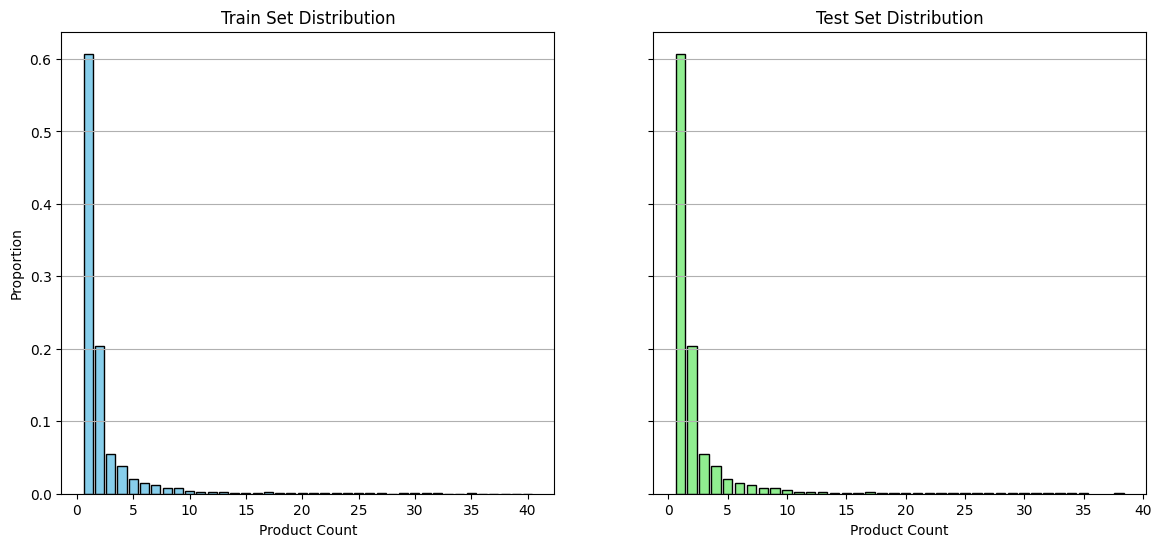

Now that both training and test sets are balanced and appropriately stratified by product count (i.e. neither set is biased towards more active members than the other), we can proceed with modeling.

## 3 - Model Training and Evaluation

First, we use the KMeans cluster model from scikit-learn on the training set and get the silhouette score. The silhouette score is used to evaluate the model. It measures how similar a point is to 
its own cluster commpared to other clusters, with a score ranging between -1 and 1.
- Close to 1 means well-defined clusters
- Close to 0 means overlapping or poorly-defined clusters (or lack thereof)
- Less than 0: Incorrect clustering or serious issues with cluster separation

### 3.1 - Elbow Method to find the best n_clusters for KMeans

First, use the Elbow Method to find the optimal number of clusters for your KMeans model without manually testing each value. The Elbow Method involves running KMeans with different values of ```n_clusters``` and plotting the intra-cluster sum of squares ```icss_values``` for each value. The "elbow" point in the plot is typically considered the optimal number of clusters.

In [ ]:
from sklearn.cluster import KMeans

# Define a range of potential cluster numbers
cluster_range = range(1, 11)
icss_values = []

# Make a copy of the original dataframe, but exclude the first 7 columns (including date-time values)
X = df_train.iloc[:,7:]

# Run KMeans for each number of clusters in the range and store the inertia value
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    icss_values.append(kmeans.inertia_)

# Plot the inertia values for each number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, icss_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Intra-Cluster Sum of Squares')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

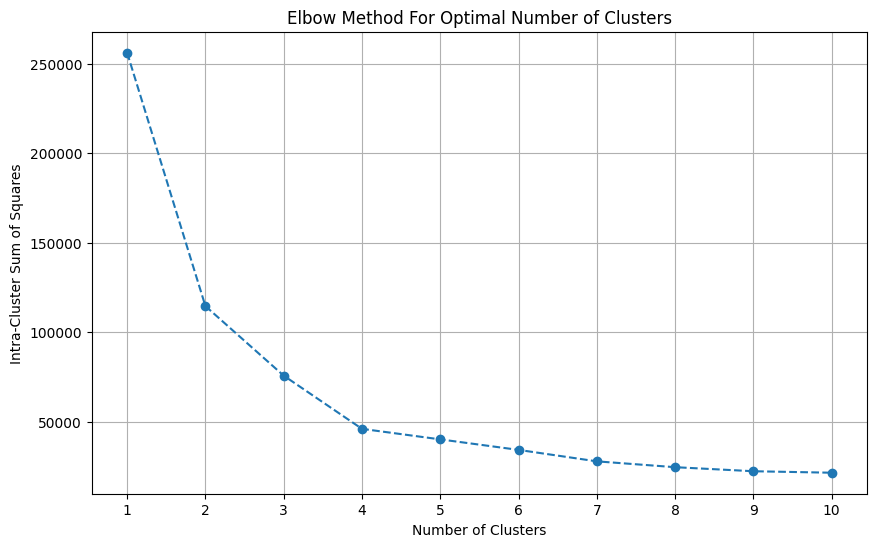

After running the elbow method, the optimal number of clusters can be chosen as 4. However, as we will find out later, the Gaussian Mixture Model found 6 clusters even with the initial ```n_components``` was set to 4. So I decided to set ```n_clusters``` to 6 for the rest of this project.

Note: It helped to drop the ```_Scaled``` features from the dataset because the Elbow plot is now much smoother and less choppier.

In [ ]:
n_clusters = 6

### 3.2 - KMeans without PCA

In [ ]:
from sklearn.metrics import silhouette_score

# Hyperparameter n_clusters set after the elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Apply KMeans clustering and add a new prediction column
df_train["KMeans_Cluster"] = kmeans.fit_predict(X)

# Calculate Silhouette Score
score = silhouette_score(X, df_train["KMeans_Cluster"])
print("Silhouette Score for Product Clustering:", score)


Without using PCA, the silhouette score for KMeans is 0.66. 

```Silhouette Score for Product Clustering: 0.6587279734722213```

Now run the KMeans again with PCA:

### 3.3 - KMeans with PCA

In [ ]:
# Get the first 2 PCA columns from the df_train dataframe into a 2D array
X_pca_2d = df_train[['PCA_1', 'PCA_2']].values

# Get the first 3 PCA columns from the df_train dataframe into a 3D array
X_pca_3d = df_train[['PCA_1', 'PCA_2', 'PCA_3']].values

# Clustering on 2D PCA results
clusters_2d = kmeans.fit_predict(X_pca_2d)
score_2d = silhouette_score(X_pca_2d, clusters_2d)
print("Silhouette Score for 2D PCA:", score_2d)

# Clustering on 3D PCA results
clusters_3d = kmeans.fit_predict(X_pca_3d)
score_3d = silhouette_score(X_pca_3d, clusters_3d)
print("Silhouette Score for 3D PCA:", score_3d)

```Silhouette Score for 2D PCA: 0.7782573740213615```

```Silhouette Score for 3D PCA: 0.7436986215882475```

Plot the results below:

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 2D PCA
scatter_2d = ax1.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=clusters_2d,
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.7,
)
ax1.set_title("2D PCA Cluster Visualization - Segmentation by Product")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
legend_2d = ax1.legend(*scatter_2d.legend_elements(), title="Clusters")
ax1.add_artist(legend_2d)

# Plot 3D PCA
ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=clusters_3d,
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.7,
)
ax2.set_title("3D PCA Cluster Visualization - Segmentation by Product")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
legend_3d = ax2.legend(*scatter_3d.legend_elements(), title="Clusters")
ax2.add_artist(legend_3d)

plt.show()



KMeans with PCA plots below:

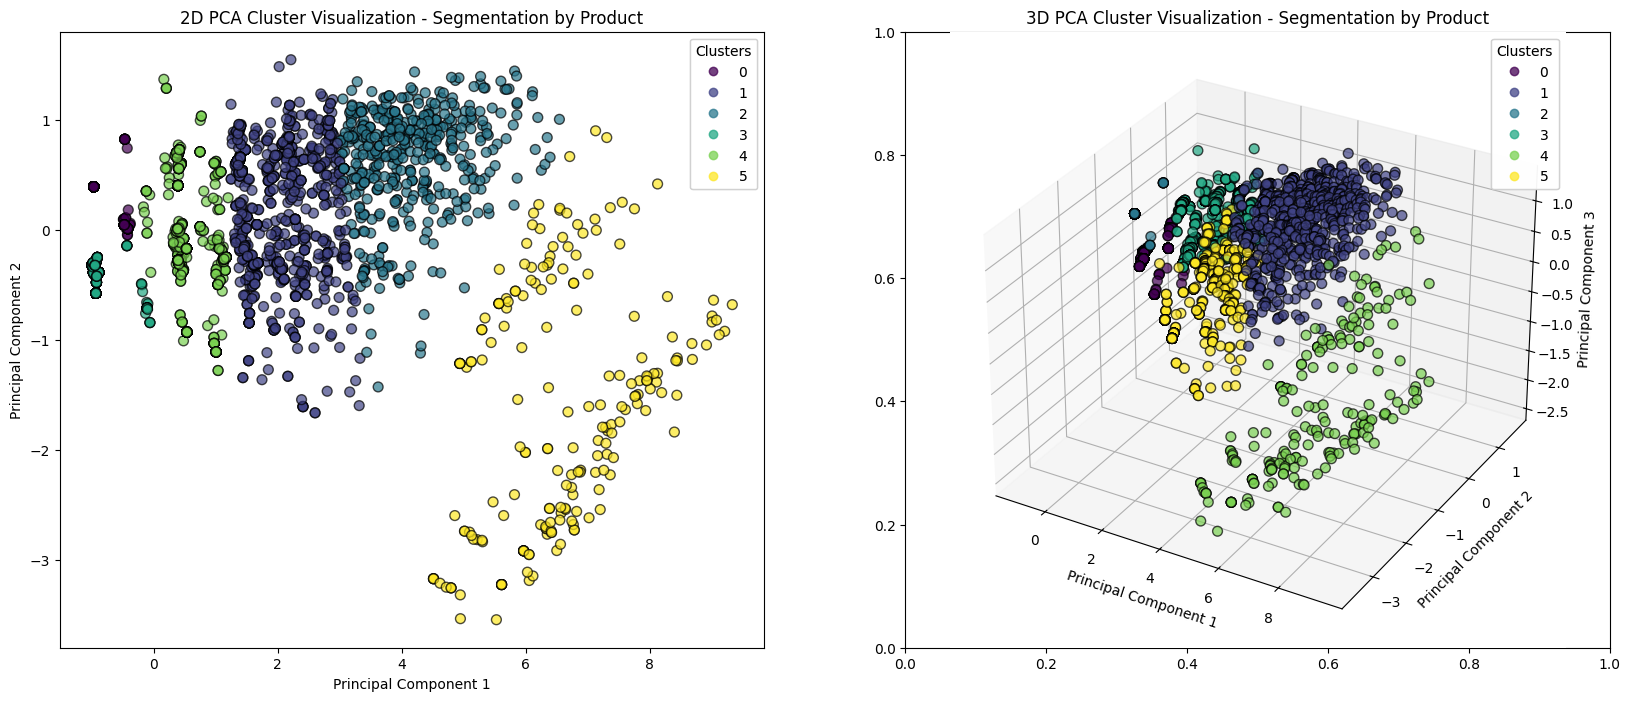

While 2D PCA scores slightly higher than 3D, the cluster divisions seem somewhat arbitrary on the 2D plot. The 3D plot is more informative when clusters are viewed in 3D space.


Assign the clusters to the original dataset:

In [ ]:
# Count the number of customers in each cluster and plot the historgram
df_train["KMeans_3D_PCA_Cluster"] = clusters_3d
cluster_counts = df_train["KMeans_3D_PCA_Cluster"].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(
    cluster_counts.index,
    cluster_counts.values,
    color="skyblue",
    edgecolor="k",
)
plt.xlabel("Cluster Number")
plt.ylabel("Number of Customers")
plt.title("Number of Customers in Each Cluster")
plt.xticks(cluster_counts.index)
plt.grid(axis="y")
plt.show()
plt.close()

Number of customers in each cluster as plotted below:

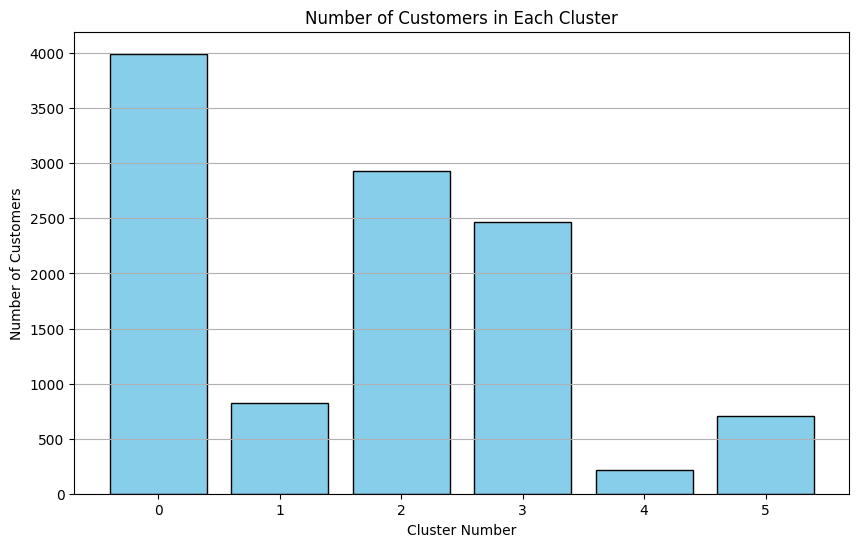

## 4 - Other Clustering Models

Use ```X_pca_2d``` and ```X_pca_3d``` transformed datasets, and join best results with ```df_train``` for comparison.

- 4.1 - Graph Clustering with Louvain
- 4.2 - Density-based Clustering with HBDSCAN
- 4.3 - Gaussian Mixture Models

### 4.1 - Graph Clustering With Louvain (using 3D PCA)

In [ ]:
# import matplotlib.cm as cm
# import networkx as nx
# from community import community_louvain
# from sklearn.neighbors import kneighbors_graph

# # Load the graph
# knn_graph = kneighbors_graph(X_pca_3d[:4000], n_neighbors=3, mode='distance', include_self=False)
# G = nx.Graph(knn_graph)

# # Compute the best partition
# partition = community_louvain.best_partition(G)

# # Plot the graph and color nodes according to their community
# pos = nx.spring_layout(G)
# cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
# nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=5,
#                        cmap=cmap, node_color=list(partition.values()))
# nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='none')
# plt.show()

# louvain_labels = list(partition.values())
# louvain_silhouette_3d = silhouette_score(X_pca_3d[:4000], louvain_labels)
# print("Silhouette Score for Louvain Clustering with 3D PCA:", louvain_silhouette_3d)


With a poor silhouette score near zero, the Louvain method isn't helpful for this specific use case.

### 4.2 - Density-based Spatial Clustering With HDBSCAN

In [ ]:
import hdbscan

# Testing hyperparameter value for min_cluster_size
minimum_cluster_size = 200

# Assuming your PCA-reduced data is in a variable called 'pca_data'
clusterer_2d = hdbscan.HDBSCAN(min_cluster_size=200)
labels_2d = clusterer_2d.fit_predict(X_pca_2d)

clusterer_3d = hdbscan.HDBSCAN(min_cluster_size=200)
labels_3d = clusterer_3d.fit_predict(X_pca_3d)

# Calculate Silhouette Score
score_hdb_2d = silhouette_score(X, labels_2d)
print("Silhouette Score for HDBSCAN Clustering with 2D PCA:", score_hdb_2d)

score_hdb_3d = silhouette_score(X, labels_3d)
print("Silhouette Score for HDBSCAN Clustering with 3D PCA:", score_hdb_3d)

# Plot in 2D and 3D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

scatter_2d = ax1.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=labels_2d,
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.7,
)
ax1.set_title("2D PCA Cluster Visualization - Segmentation by Product")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
legend_2d = ax1.legend(*scatter_2d.legend_elements(), title="Clusters")
ax1.add_artist(legend_2d)

ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=labels_3d,
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.7,
)
ax2.set_title("3D PCA Cluster Visualization - Segmentation by Product")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
legend_3d = ax2.legend(*scatter_3d.legend_elements(), title="Clusters")
ax2.add_artist(legend_3d)

plt.show()

n_clusters = len(np.unique(labels_3d[labels_3d != -1]))
print(f"Number of clusters: {n_clusters}")  


Plot with HDBSCAN segmentation using a 3D PCA-processed dataset. No clear cluster grouping is seen here:

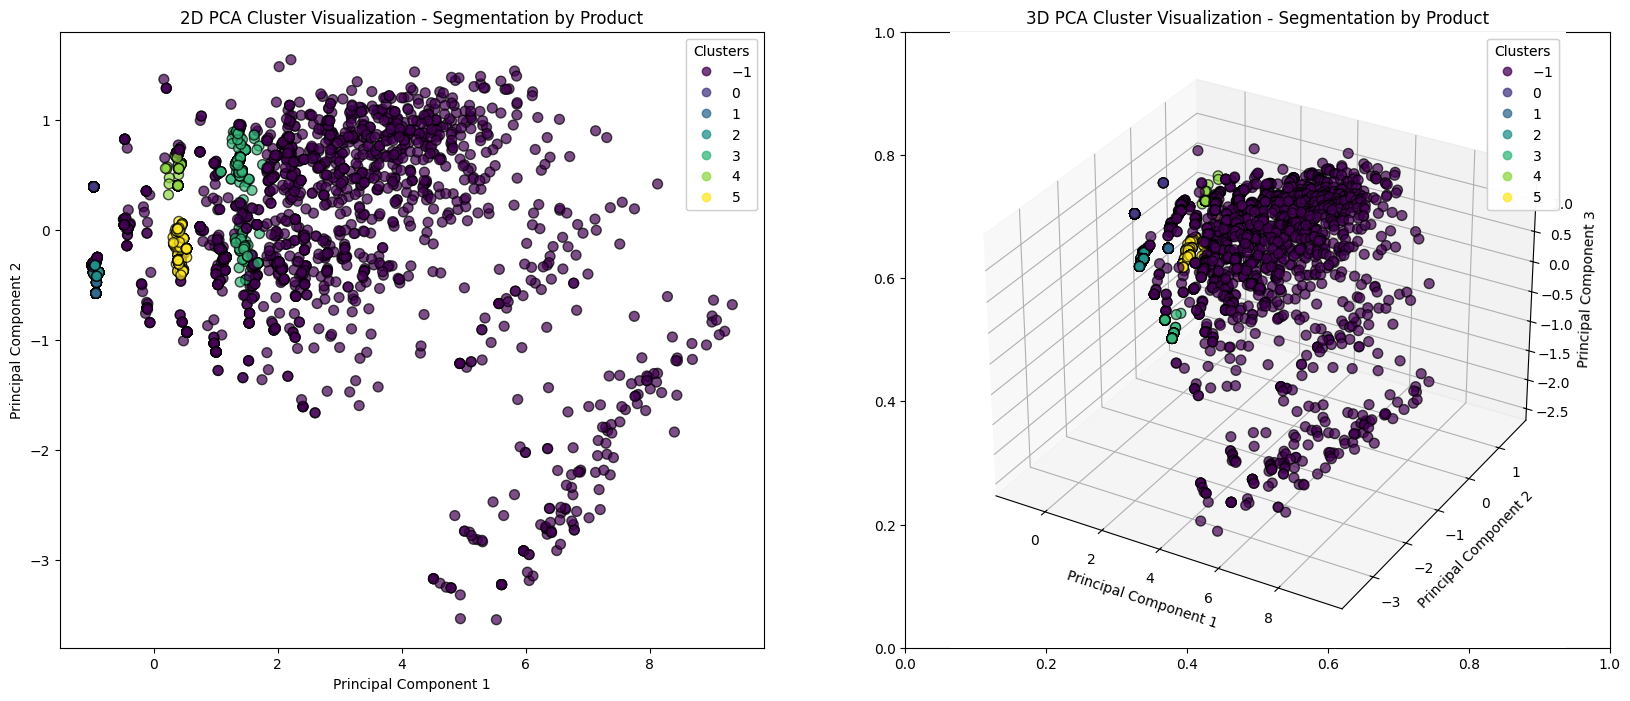

Silhouette score results for HDBSCAN:

```Silhouette Score for HDBSCAN Clustering with 2D PCA: 0.6409524404865447```

```Silhouette Score for HDBSCAN Clustering with 3D PCA: 0.6750004492352014```

### 4.3 - Gaussian Mixture Model (GMM)

In [ ]:
from sklearn.mixture import GaussianMixture

# Fit GMM on the PCA-transformed data (X_pca_2d)
gmm_2d = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels_2d = gmm_2d.fit_predict(X_pca_2d)

# Fit GMM on the PCA-transformed data (X_pca_3d)
gmm_3d = GaussianMixture(n_components=n_clusters, random_state=42)
gmm_labels_3d = gmm_3d.fit_predict(X_pca_3d)

# Calculate Silhouette Scores
gmm_silhouette_2d = silhouette_score(X, gmm_labels_2d)
print("Silhouette Score for GMM Clustering with 2D PCA:", gmm_silhouette_2d)

gmm_silhouette_3d = silhouette_score(X, gmm_labels_3d)
print("Silhouette Score for GMM Clustering with 3D PCA:", gmm_silhouette_3d)

# Plot in 2D and 3D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

scatter_2d = ax1.scatter(
    X_pca_2d[:, 0],
    X_pca_2d[:, 1],
    c=gmm_labels_2d,
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.7,
)
ax1.set_title("2D PCA Cluster Visualization - Segmentation by Product")
ax1.set_xlabel("Principal Component 1")
ax1.set_ylabel("Principal Component 2")
legend_2d = ax1.legend(*scatter_2d.legend_elements(), title="Clusters")
ax1.add_artist(legend_2d)

ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(
    X_pca_3d[:, 0],
    X_pca_3d[:, 1],
    X_pca_3d[:, 2],
    c=gmm_labels_3d,
    cmap="viridis",
    edgecolor="k",
    s=50,
    alpha=0.7,
)
ax2.set_title("3D PCA Cluster Visualization - Segmentation by Product")
ax2.set_xlabel("Principal Component 1")
ax2.set_ylabel("Principal Component 2")
ax2.set_zlabel("Principal Component 3")
legend_3d = ax2.legend(*scatter_3d.legend_elements(), title="Clusters")
ax2.add_artist(legend_3d)

plt.show()

gmm_n_clusters = len(np.unique(gmm_labels_3d))
print(f"Number of clusters: {gmm_n_clusters}")

Plot with GMM labeling using 3D PCA-processed data. Clustering is much clearer here!

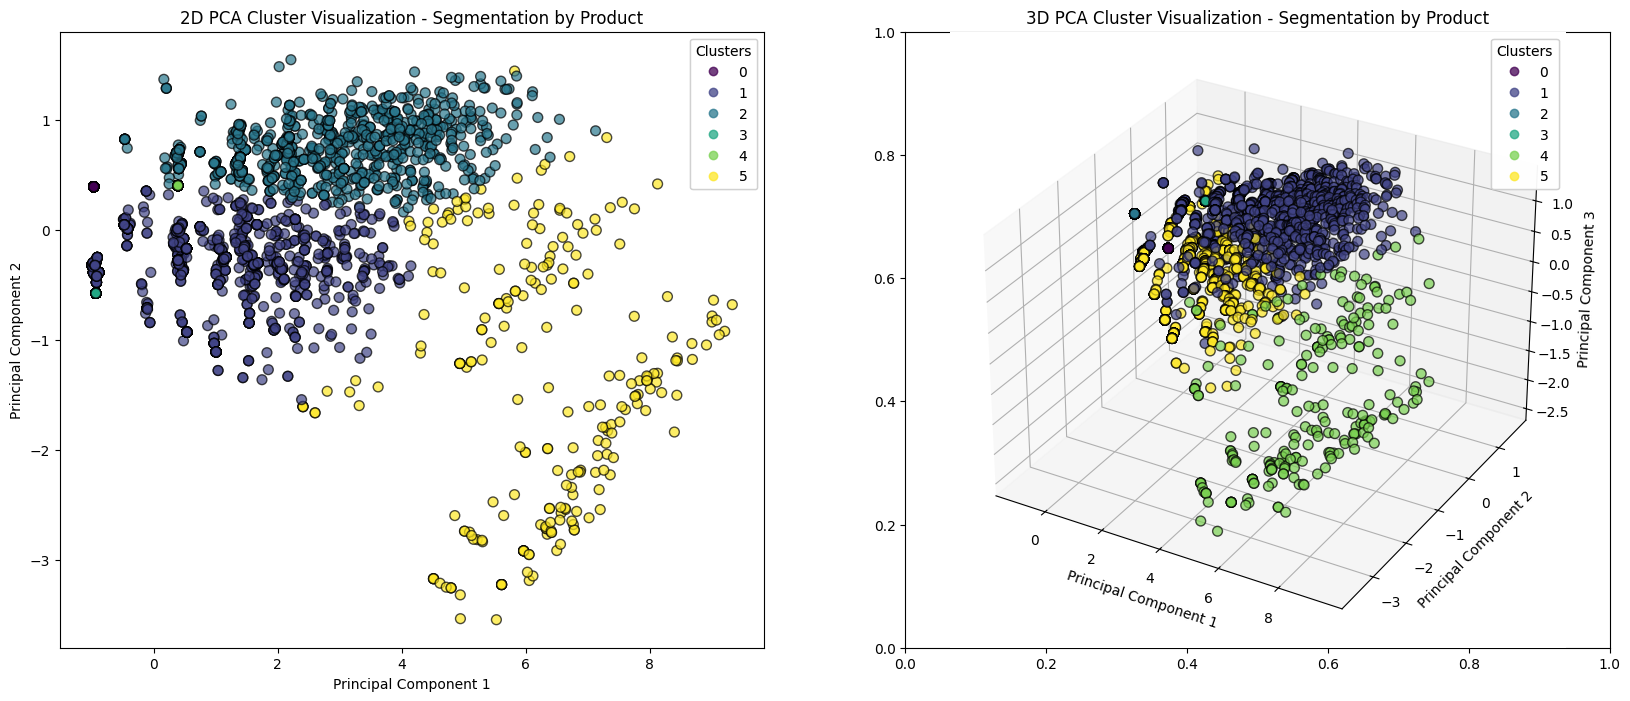

Silhouette scores:

```Silhouette Score for GMM Clustering with 2D PCA: 0.6598976017837708```

```Silhouette Score for GMM Clustering with 3D PCA: 0.6641588219988388```

Number of clusters: ```6```


Assign the 3D PCA Kmeans and GMM clusters to the original training set:

In [ ]:
df_train["GMM_3D_PCA_Cluster"] = gmm_labels_3d

Now plot the number of customers in each cluster, by model:

In [ ]:

# Define the cluster columns and their corresponding colors and titles
cluster_columns = ['KMeans_Cluster', 'KMeans_3D_PCA_Cluster', 'GMM_3D_PCA_Cluster']

# Model titles and colors for all plots onward
titles = { 
    'KMeans_Cluster': 'KMeans (No PCA)', 
    'KMeans_3D_PCA_Cluster': 'KMeans (3D PCA)', 
    'GMM_3D_PCA_Cluster': 'GMM (3D PCA)',
}
colors = { 
    'KMeans_Cluster': 'orange',
    'KMeans_3D_PCA_Cluster': 'skyblue',
    'GMM_3D_PCA_Cluster': 'pink',
}

# Count the number of customers in each cluster
clusters_k = df_train["KMeans_Cluster"].value_counts().sort_index()
cluster_counts = df_train["KMeans_3D_PCA_Cluster"].value_counts().sort_index()
cluster_counts_gmm = df_train["GMM_3D_PCA_Cluster"].value_counts().sort_index()

# Create an array of cluster indices
cluster_indices = np.arange(len(cluster_counts))

# Set the width of the bars
bar_width = 0.25

# Create the plot
plt.figure(figsize=(12, 6))

# Plot KMeans without PCA cluster counts
plt.bar(
    cluster_indices - bar_width,
    clusters_k.values,
    width=bar_width,
    color=colors["KMeans_Cluster"],
    edgecolor="k",
    label=titles["KMeans_Cluster"]
)

# Plot KMeans 3D PCA cluster counts
plt.bar(
    cluster_indices,
    cluster_counts.values,
    width=bar_width,
    color=colors["KMeans_3D_PCA_Cluster"],
    edgecolor="k",
    label=titles["KMeans_3D_PCA_Cluster"]
)

# Plot GMM 3D PCA cluster counts
plt.bar(
    cluster_indices + bar_width,
    cluster_counts_gmm.values,
    width=bar_width,
    color=colors['GMM_3D_PCA_Cluster'],
    edgecolor="k",
    label=titles["GMM_3D_PCA_Cluster"]
)

# Add labels and title
plt.xlabel("Cluster Number")
plt.ylabel("Number of Customers")
plt.title("Number of Customers in Each Cluster")
plt.xticks(cluster_indices, cluster_counts.index)
plt.legend()
plt.grid(axis="y")

# Show plot
plt.show()

Comparison between segmentation via KMeans and GMM models using 3D PCA-processed data versus the non-PCA KMeans "control":

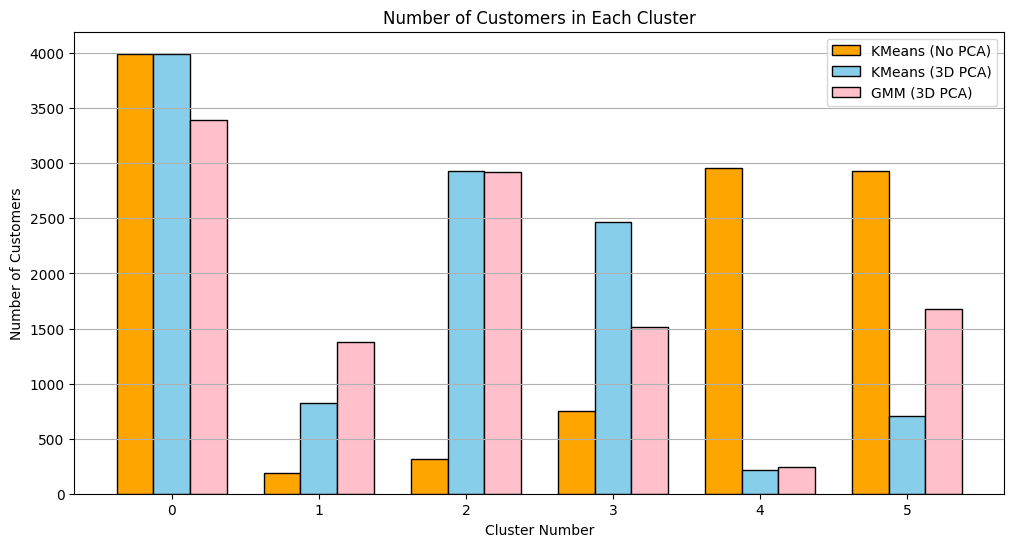

## 5 - Model Discussion and Evaluation

### 5.1 - KMeans

KMeans was used with 2D and 3D PCA-processed data to understand how the customer list is clustered or grouped, and whether useful information can be gleaned from the results.

The silhouette score is used to evaluate the model. It measures how similar a point is to its own cluster commpared to other clusters, with a score ranging between -1 and 1.
- Close to 1 means well-defined clusters
- Close to 0 means overlapping or poorly-defined clusters (or lack thereof)
- Less than 0: Incorrect clustering or serious issues with cluster separation

The KMeans model scored well on 2D and 3D PCA-processed data, at between 0.7 and 0.8. Increasing the number of clusters from 4 to 6 improved the silhouette score by 0.07. Without pre-processing data using PCA, the KMeans silhouette score was only 0.49.

However, KMeans has some limitations that prevent use of this model for broader use case scenarios, such as segmentation on various datasets other than Kajabi or ConvertKit.

For instance, it cannot be used to recommend products to a specific group of customers. For that, a recommender system would be used. Being an unsupervised ML algorithm, it cannot identify each cluster/segment with meaningful information. Post-model analysis is needed to identify and label these clusters accordingly (then potentially train/test a classification model on those labels and evaluate the predictions for usefulness). 

Also, KMeans requires the number of clusters to be specified prior to running the model, given that n_clusters is one of the most important hyperparameters. This is limiting since we may not know how many segments/groups actually exist within our user list.

Other limitations of KMeans include:
- Assumes that clusters are spherical with equal variance (not the case for the above results)
- Sensitive to outliers that affect the centroid positions, leading to bias
- Lacks flexibility with hyperparameters (users shouldn't have to set n_clusters themselves)

Due to these limitations, other models have been tested.

### 5.2 - Graph Clustering - Louvian Method

As an alternative to KMeans, the Louvain graph clustering method captures non-linear relationships between customers based on their interactions with products or tags. This method may not be readily applicable for this use case, however, as non-linearity is not expected and each customer makes product purchases independent of each other.

This was attempted, but the model took much longer to run on this dataset. Giving it a smaller sample of the dataset enabled the model to run within a minute, but the silhouette score was close to 0 (slightly negative) and the resulting visualization did not show any clear clustering. It isn't clear as to why, but no further analysis was performed.

### 5.3 - Density-based clustering with HDBSCAN

HDBSCAN identifies clusters based on regions of high density separated by regions of low density. The clusters can be of varying shapes and sizes, which may not always align perfectly with the structures identified by PCA.

I tested different minimum cluster sizes ranging between 10 and 1,000 and there seems to be a trade-off between a higher silhoutte score obtained by user a lower minimum cluster size (<50) and the number of clusters. 

When using a low minimum cluster size, the model achieves a higher silhouette score (around 0.8). However, it also divides the dataset into 50-90 clusters/segments, which is too many to be useful for marketing purposes. 

Conversely, when using a higher minimum cluster size (150 or higher), the silhouette score ends up lower, but divides the dataset into far fewer clusters. 

When I set ```min_cluster_size``` to 200, the model divides the set into only 6 clusters and still achieves a silhouette score of 0.68. The plots, however, don't show clear distinctions between clusters. One large cluster that groups multiple clusters together can be seen in both 2D and 3D plots, while smaller clusters can be seen on the 2D graph. This visualization doesn't lend confidence to using this clustering method for segmentation given the dataset.

### 5.4 - Gaussian Mixture Model

Gaussian Mixture Model provides soft clustering where each customer can belong to multiple segments with different probabilities. This is very likely when multiple products or multiple account tiers are offered by a business, as was the case with the company for whom I worked as a Marketing Analytics Director.

Different values of ```n_components``` between 3 and 8 were tested, and 6 gives the best silhouette score:

Using the GMM method, the plots visualize the most probable clusters very nicely. Distinct clusters are indicated without arbitrarily splitting them. While there are six clusters, the plots show that there are three large clusters that can be used to segment the customer list.

### 5.5 - Silhouette Score Comparison

| Model Type | No PCA | 2D PCA | 3D PCA |
|------------|--------|--------|--------|
| KMeans     | 0.647  | 0.771  | 0.751  |
| GMM        | -      | 0.662  | 0.667  |
| HDBSCAN    | -      | 0.624  | 0.670  |
| Louvain    | -      | -      | -0.013 |

## 6 - Post Model Exploratory Analysis

To compare the model results in terms of how well their clusters represent the "true" segmentation of the customer list, I created plots to compare model results on the following parameters:

- How many products users within each segment has
- How many times users of each segment have signed in to their accounts
- Average number of purchases of each product type, showing which clusters buy the most products of each type
- Frequencies of product types by model and by cluster, showing whether a segment favors a certain type of product over another

In [ ]:
import seaborn as sns

# Adjusting the figure size
plt.figure(figsize=(15, 6))

# Iterate through the cluster columns and create the Product Count plots
for i, (cluster_col, color, title) in enumerate(zip(cluster_columns, colors, titles), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=cluster_col, y='Product_Count', data=df_train, width=0.3, color=colors[cluster_col])
    plt.title(titles[cluster_col])
    plt.xlabel('Cluster')
    plt.ylabel('Number of Products')

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()


There are clear differences between how the models organize users into clusters based on whether PCA is used or not. Without PCA, KMeans puts the most frequent product buyers into cluster 1, whereas models using 3D PCA tends to organize them into cluster 4. The GMM model, compared to KMeans (with 3D PCA) organizes users into clusters such that there are fewer outliers than KMeans 3D PCA. 

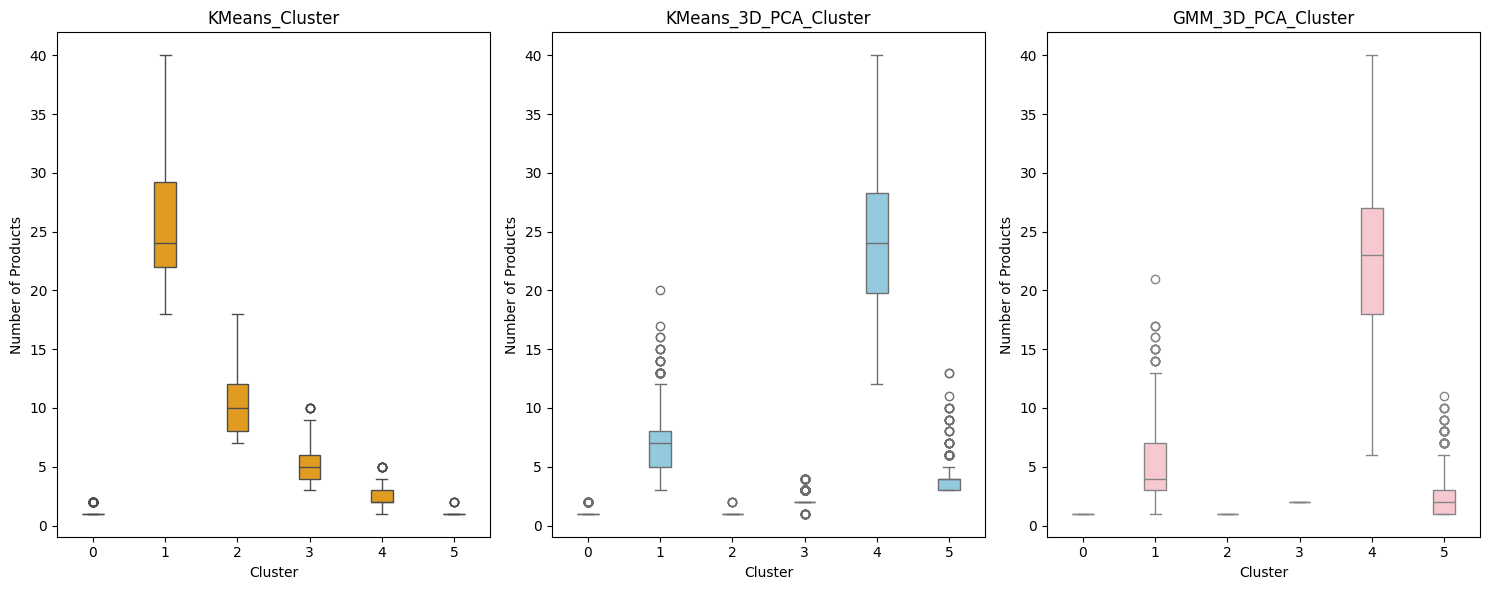

In [ ]:
# Calculate probability that a customer is already a Member
member_probabilities_kmeans = df_train.groupby('KMeans_Cluster')['Is_Member'].mean()
member_probabilities_kmeans_3d_pca = df_train.groupby('KMeans_3D_PCA_Cluster')['Is_Member'].mean()
member_probabilities_gmm_3d_pca = df_train.groupby('GMM_3D_PCA_Cluster')['Is_Member'].mean()

# Plotting
plt.figure(figsize=(12, 6))

# Plot for KMeans_Cluster
bars_kmeans = plt.bar(member_probabilities_kmeans.index - 0.2, member_probabilities_kmeans.values, width=0.2, color=colors["KMeans_Cluster"], label=titles["KMeans_Cluster"])

# Plot for KMeans_3D_PCA_Cluster
bars_kmeans_3d_pca = plt.bar(member_probabilities_kmeans_3d_pca.index, member_probabilities_kmeans_3d_pca.values, width=0.2, color=colors["KMeans_3D_PCA_Cluster"], label=titles["KMeans_3D_PCA_Cluster"])

# Plot for GMM_3D_PCA_Cluster
bars_gmm_3d_pca = plt.bar(member_probabilities_gmm_3d_pca.index + 0.2, member_probabilities_gmm_3d_pca.values, width=0.2, color=colors["GMM_3D_PCA_Cluster"], label=titles["GMM_3D_PCA_Cluster"])

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Probability of Being a Member')
plt.title('Probability that a Customer is Already a Member by Clustering Algorithm')
plt.xticks(range(max(df_train['KMeans_Cluster'].max(), df_train['KMeans_3D_PCA_Cluster'].max(), df_train['GMM_3D_PCA_Cluster'].max()) + 1))
plt.ylim(0, 1)
plt.legend()

plt.grid(axis='y')
plt.show()

Since it is clear which clusters contain the most frequent buyers, the likelihood that they are paying members who are subscribed to the business is much higher than other clusters. This means all models are weighing the number of product purchases, frequent sign-ins, and memberships heavily compared to other features.

Interestingly, the models groups these members differently when using PCA.

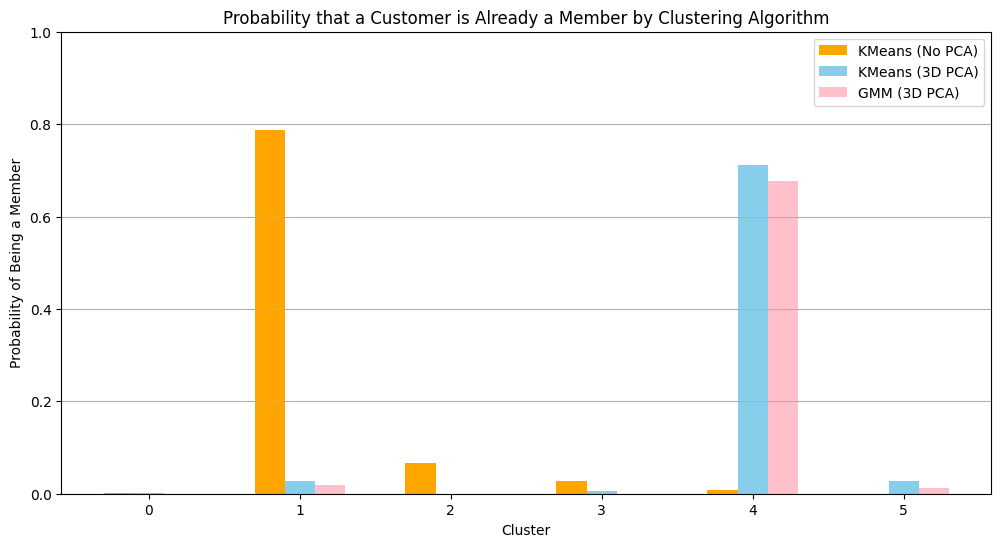

In [ ]:
# Adjusting the figure size
plt.figure(figsize=(15, 6))

# Iterate through the cluster columns and create the Sign In Count plots
for i, (cluster_col, color, title) in enumerate(zip(cluster_columns, colors, titles), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=cluster_col, y='Sign In Count', data=df_train, width=0.3, color=colors[cluster_col])
    plt.title(titles[cluster_col])
    plt.xlabel('Cluster')
    plt.ylabel('Number of Sign-ins')

# Adjusting layout and displaying the plot
plt.tight_layout()
plt.show()


Similarly to product counts, each model groups users with frequent sign-ins together with frequent purchasers and likely members, which makes sense because these characteristics have a lot of overlap between the same users. In other words, users who bought a lot of products and/or are paying members are more likely to log into their accounts more frequently. 

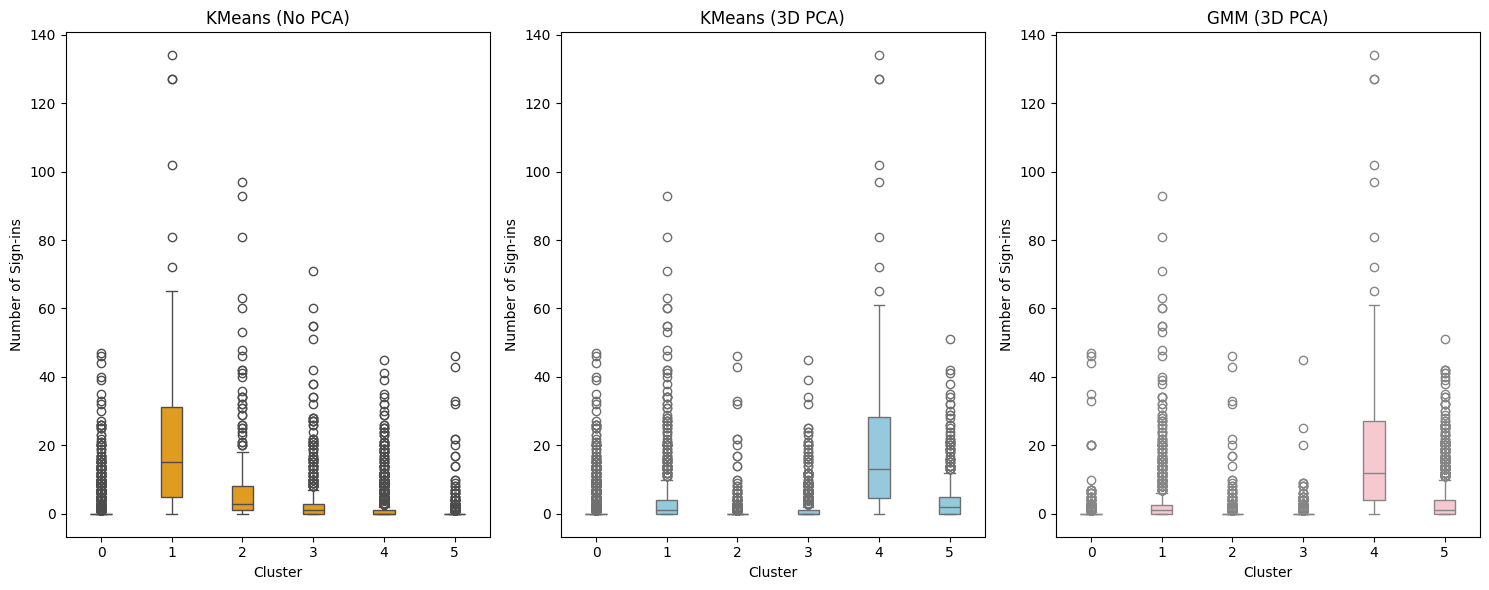

This is valuable information that can be used for customer segmentation because we can then forecast churn (using a new feature "Days Since Last Activity") or make membership offers to frequent purchasers who are not members yet.

In [ ]:
# Define groups of products based on their names
labels = ['Business_Products', 'Google_Analytics_Products', 'Advertising_Products']

business_products = [
    'agency jumpstart', 'agency lead generation bootcamp', 'agency survival bootcamp',
    'better clients accelerator', 'ddu scale+', 'ga4 business strategy workshop', 'ga4 agency blueprint -',
    'google ads agency blueprint', 'linked jumpstart', 'linkedin outreach bootcamp', 'profit pillars', 
    'project apollo accelerator program', 'revenue renegade workshop', 'sales jumpstart', 'starting from zero',
]

google_analytics_products = [
    'analysis with google analytics 4 certificate', 'bigquery blueprint cya recordings', 
    'bigquery cya blueprint', 'ga4 cya blueprint -', 'looker studio blueprint live', 
    'ga4 diy process toolbox - essentials edition', 'ga4 diy process toolbox - pro edition', 
    'ga4 ecommerce deep dive with charles farina', 'ga4 for seo deep dive', 
    'ga4 migration deep dive with fred pike and martin suttill', 'ga4 migration process', 
    'gads cya blueprint -', 'google analytics 4 bootcamp',
]

advertising_products = [
    'facebook ads strategy', 'fb ads mastery', 'fb ads on a budget', 
    'intro to shopping ads', 'paid ads pack', 'meta ads blueprint', 'meta ads blueprint live', 
    'traffic with google search ads certificate', 'google search ads blueprint live', 'google search ads mastery',
]

# Calculate totals for each category
df_train[labels[0]] = df_train[business_products].sum(axis=1)
df_train[labels[1]] = df_train[google_analytics_products].sum(axis=1)
df_train[labels[2]] = df_train[advertising_products].sum(axis=1)

# Group by cluster segments and calculate mean product counts for KMeans and GMM with 3D PCA
grouped_kmeans_no_pca_mean = df_train.groupby('KMeans_Cluster')[labels].mean()
grouped_kmeans_3d_pca_mean = df_train.groupby('KMeans_3D_PCA_Cluster')[labels].mean()
grouped_gmm_mean = df_train.groupby('GMM_3D_PCA_Cluster')[labels].mean()

# Plotting
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))  # One row with three plots

# Function to adjust x positions for side-by-side bars
def adjust_x_positions(x, offset, width):
    return x + offset * width

# Set bar width and offsets
bar_width = 0.25
offsets = [-1, 0, 1]  # Adjust for three clusters

# Prepare the plotting data
grouped_data_mean = [grouped_kmeans_no_pca_mean, grouped_kmeans_3d_pca_mean, grouped_gmm_mean]
axes_indices = [0, 1, 2]
legend_items = [label.replace('_', ' ') for label in labels]

# Find the maximum y-value for setting equal y-axis limits
max_y_value = max([grouped[label].max() for grouped in grouped_data_mean for label in labels])

# Iterate through the dataframes and create the plots
for i, (grouped, title, ax_idx) in enumerate(zip(grouped_data_mean, titles, axes_indices)):
    x = grouped.index
    for j, label in enumerate(labels):
        axes[ax_idx].bar(adjust_x_positions(x, offsets[j], bar_width), grouped[label], width=bar_width, label=legend_items[j])
    axes[ax_idx].set_title(titles[cluster_col])
    axes[ax_idx].set_xlabel('Cluster')
    axes[ax_idx].set_ylabel('Average Number of Products')
    axes[ax_idx].legend(loc='upper left')
    axes[ax_idx].set_xticks(x)
    axes[ax_idx].set_xticklabels(x, rotation=0)
    axes[ax_idx].set_ylim(0, max_y_value + 0.5)

plt.tight_layout()
plt.show()

When determining which types of products each segment tends to favor, it can be seen that the segment (cluster 1 without PCA, or cluster 4 with 3D PCA) with frequent purchasers and/or members tends to favor all three types of products. This shows strong customer loyalty and brand affinity where these customers buy our products regardless of product type. 

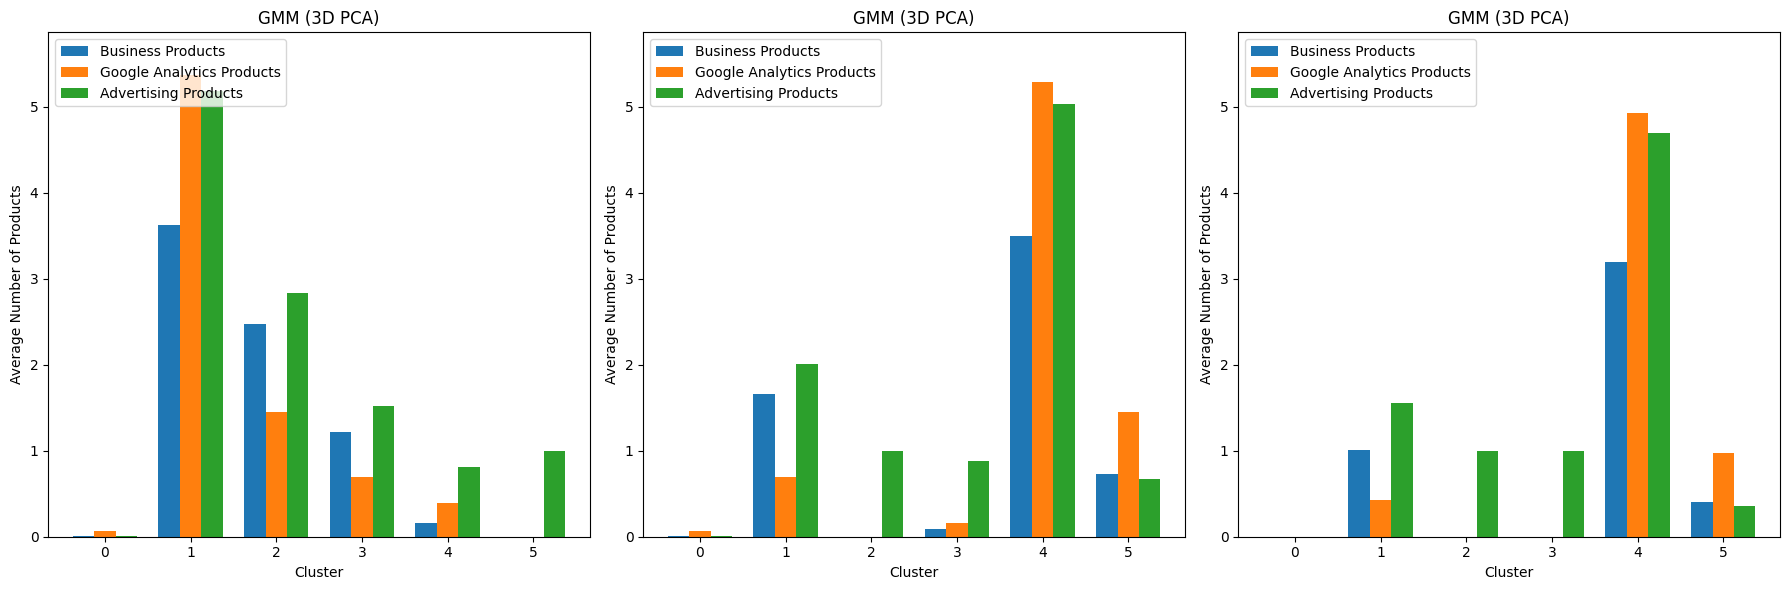

For other segments, KMeans without PCA tends to distribute product type affinity among other clusters, which makes it unclear as to which segments favor which product type.

However, when using PCA, both KMeans and GMM show that cluster 5, in particular, strongly favors Google Analytics products over other product types. Conversely, cluster 1 favors business and advertising product types over Google Analytics. Clusters 2 and 3 also favor Advertising products only. 

This is useful because we now know which segments are more likely to buy which product type, and thus can confidently offer certain products to certain clusters. For example, we can feel confident in offering business products to cluster 1, while refraining from offering Google Analytics products to that same cluster. We would offer Google Analytics products to cluster 5 instead. 

For offers involving advertising products only, we would feel confident in offering those to clusters 2 and 3, which is valuable to know because these two clusters have not shown much engagement. Making relevant offers to low-engagement users is crucial in bringing them back, increasing engagement, obtaining new paying customers, and retaining existing customers, thereby boosting Average Order Value.

In [ ]:
# Group by cluster segments and calculate frequencies
grouped_counts_kmeans = df_train.groupby('KMeans_Cluster')[labels].apply(lambda x: x.astype(bool).sum(axis=0))
grouped_counts_kmeans_3d_pca = df_train.groupby('KMeans_3D_PCA_Cluster')[labels].apply(lambda x: x.astype(bool).sum(axis=0))
grouped_counts_gmm_3d_pca = df_train.groupby('GMM_3D_PCA_Cluster')[labels].apply(lambda x: x.astype(bool).sum(axis=0))

# Normalize frequencies
grouped_norm_kmeans = grouped_counts_kmeans.div(grouped_counts_kmeans.sum(axis=1), axis=0)
grouped_norm_kmeans_3d_pca = grouped_counts_kmeans_3d_pca.div(grouped_counts_kmeans_3d_pca.sum(axis=1), axis=0)
grouped_norm_gmm_3d_pca = grouped_counts_gmm_3d_pca.div(grouped_counts_gmm_3d_pca.sum(axis=1), axis=0)

# Plotting normalized frequencies using stacked horizontal bar charts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))  # Two rows with three plots

# Prepare the plotting data
y = np.arange(len(labels))  # Number of product types
bar_width = 0.25  # Width of the bars

# Iterate through each cluster and plot normalized horizontal bars for KMeans
for i, (cluster_name, counts) in enumerate(grouped_norm_kmeans.iterrows()):
    row_idx = i // 3
    col_idx = i % 3
    axes[row_idx, col_idx].barh(y + bar_width, counts.values, bar_width, label=legend_items, color=colors["KMeans_Cluster"])
    axes[row_idx, col_idx].set_yticks(y + bar_width / 2)
    if col_idx % 3 == 0:
        axes[row_idx, col_idx].set_yticklabels(legend_items)
    else: axes[row_idx, col_idx].set_yticklabels("")
    axes[row_idx, col_idx].set_xlabel('Normalized Frequency')
    axes[row_idx, col_idx].set_xlim(0, 1.1)
    axes[row_idx, col_idx].set_title(f'Product Type Frequencies in Cluster {cluster_name}')

# Iterate through each cluster and plot normalized horizontal bars for KMeans 3D PCA
for i, (cluster_name, counts) in enumerate(grouped_norm_kmeans_3d_pca.iterrows()):
    row_idx = i // 3
    col_idx = i % 3
    axes[row_idx, col_idx].barh(y, counts.values, bar_width, color=colors["KMeans_3D_PCA_Cluster"])
    
# Iterate through each cluster and plot normalized horizontal bars for GMM 3D PCA
for i, (cluster_name, counts) in enumerate(grouped_norm_gmm_3d_pca.iterrows()):
    row_idx = i // 3
    col_idx = i % 3
    axes[row_idx, col_idx].barh(y  - bar_width, counts.values, bar_width, color=colors["GMM_3D_PCA_Cluster"])

# Create a color-coded legend of the models
handles = [
    plt.Rectangle((0, 0), 1, 1, color=color, alpha=0.7, edgecolor='none')
    for color in colors.values()
]
plt.legend(handles, titles, loc='lower right')

# Show the plot
plt.tight_layout()
plt.show()

Because the above graph shows the means of the number of product purchases, it is necessary to plot the histograms of normalized frequencies of product purchases by product type, by cluster, and by model. 

The normalized frequencies of product purchases as plotted below support the above conclusions about which cluster favors which product type.

It also uncovers potential product preferences of cluster 0, which contains users who have not bought much or signed in frequently. In which case, users in cluster 0 would be much more likely to buy a Google Analytics product than other product types.

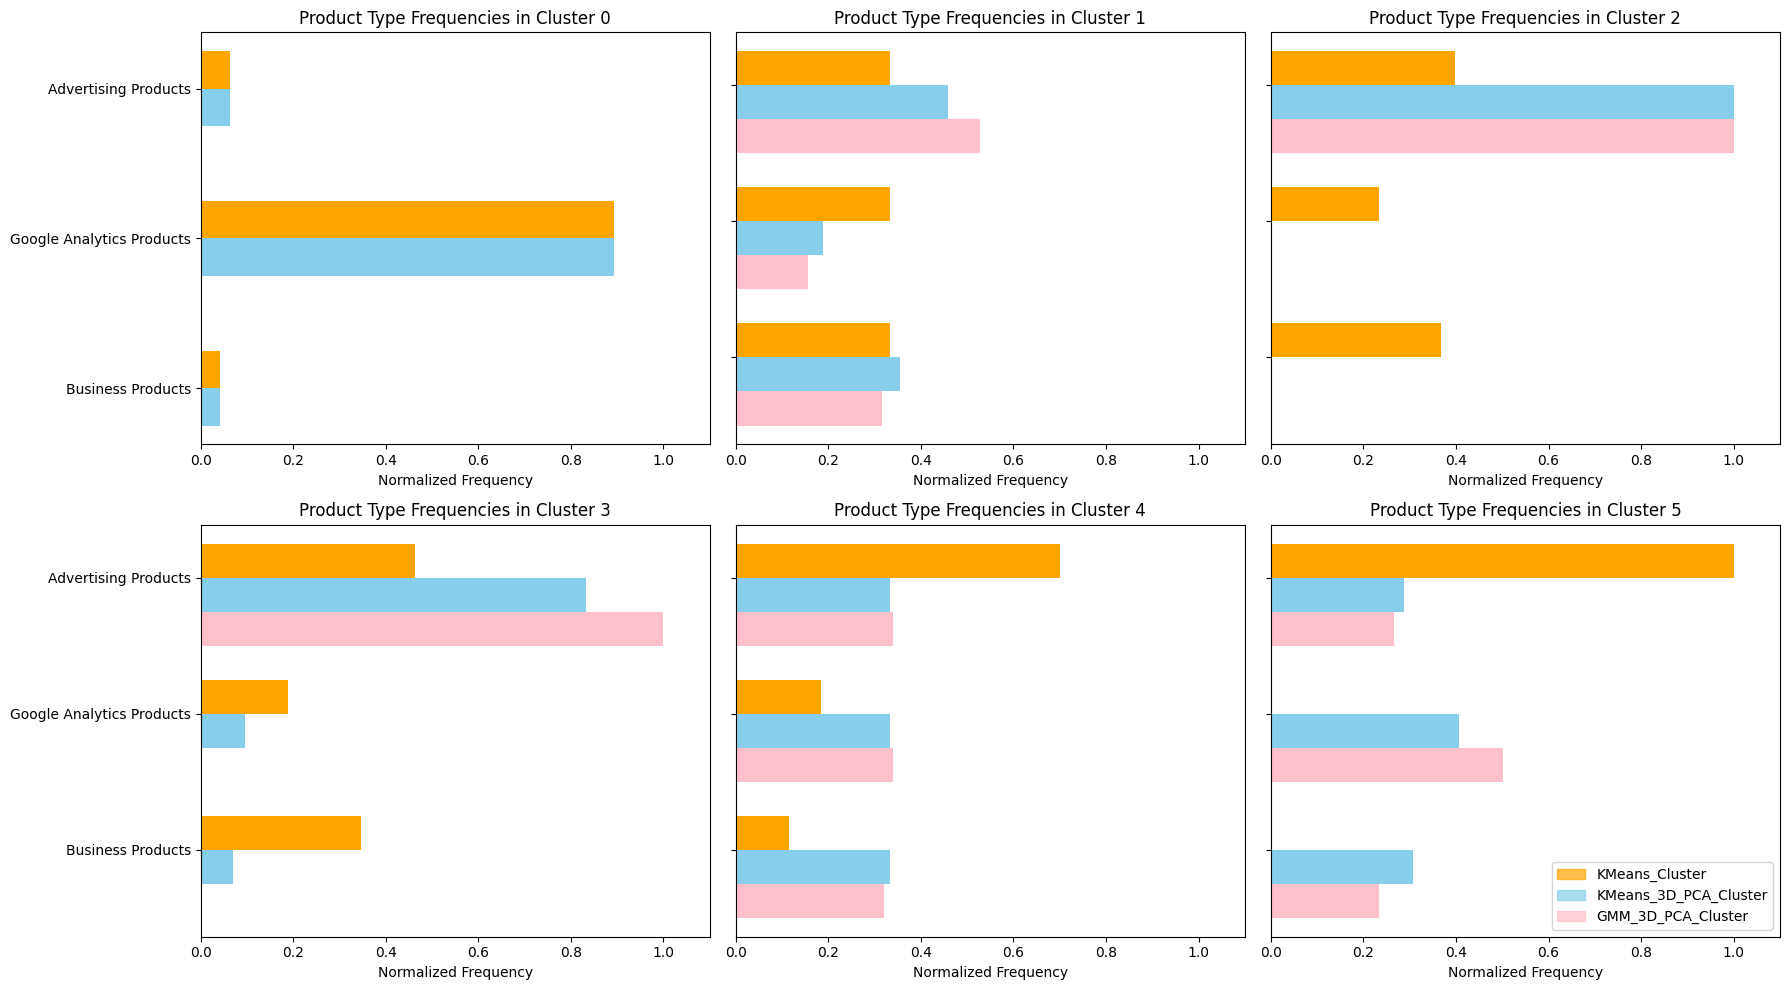